In [1]:
# downloads
!pip install osfclient pandas numpy matplotlib seaborn pygam statsmodels tqdm transformers torch einops
!pip install --upgrade transformers==4.48.0  # latest v4 still has GPT2LMHeadModel

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 57.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 45.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 77.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12

In [2]:
%cd /content

/content


In [3]:
# download Shains research data
# BOLD data
!osf -p eyp8q fetch osfstorage/LANG_y_train.csv
!osf -p eyp8q fetch osfstorage/LANG_y_dev.csv
!osf -p eyp8q fetch osfstorage/LANG_y_test.csv

# Predictors
!osf -p eyp8q fetch osfstorage/LANG_ts_X.csv

100% 8.56M/8.56M [00:00<00:00, 83.8Mbytes/s]
100% 4.41M/4.41M [00:00<00:00, 48.6Mbytes/s]
100% 4.29M/4.29M [00:00<00:00, 48.4Mbytes/s]
100% 205M/205M [00:01<00:00, 172Mbytes/s]


In [49]:
# imports
import pandas as pd
import numpy as np
from scipy import stats
from pygam import LinearGAM, s
import warnings
warnings.filterwarnings("ignore")
import math
from typing import Dict, List, Tuple
import torch
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM, __version__ as hf_version
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [6]:
# load all the files and combine the LANG

# File paths (already in Colab after osf fetch)
PRED_PATH = "LANG_ts_X.csv"       # comma-delimited
RESP1_PATH = "LANG_y_train.csv"    # whitespace-delimited
RESP2_PATH = "LANG_y_dev.csv"
RESP3_PATH = "LANG_y_test.csv"

# Load predictors
pred = pd.read_csv(PRED_PATH, delim_whitespace=True)
# Load responses
resp1 = pd.read_csv(RESP1_PATH, delim_whitespace=True)
resp2 = pd.read_csv(RESP2_PATH, delim_whitespace=True)
resp3 = pd.read_csv(RESP3_PATH, delim_whitespace=True)

resp_all = pd.concat([resp1, resp2, resp3], ignore_index=True)

# Minimal subset for use
pred_use = pred[['docid','subject','time','fROI','word','totsurp','fwprob5surp']].copy()
resp_use = resp_all[['docid','subject','time','fROI','BOLD','network']].copy()

# Standardize key columns as strings
for c in ['docid','subject','fROI']:
    pred_use[c] = pred_use[c].astype(str)
    resp_use[c] = resp_use[c].astype(str)

print("Predictors:", pred_use.shape)
print("Responses:", resp_use.shape)

print("Initial shapes -> pred:", pred_use.shape, "resp_all:", resp_use.shape)

Predictors: (1271093, 7)
Responses: (202295, 6)
Initial shapes -> pred: (1271093, 7) resp_all: (202295, 6)


In [15]:
resp_use.head(5)

,docid,subject,time,fROI,word,totsurp,fwprob5surp
0,Tulips,s061,0.403494,LangLAngG,Tulip,16.91710,6.15844
1,Tulips,s061,0.786000,LangLAngG,mania,15.22460,3.11167
2,Tulips,s061,1.260000,LangLAngG,was,5.20513,1.60044
3,Tulips,s061,1.500000,LangLAngG,a,4.97852,1.26797
4,Tulips,s061,1.590000,LangLAngG,period,12.63860,3.66045


In [19]:
# extract the stories for future use

def extract_stories_from_df(df, doc_col="docid", time_col="time", word_col="word"):
    required = {doc_col, time_col, word_col}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"Missing required columns: {missing}")
    df = df.sort_values([doc_col, time_col]).copy()

    stories = {}
    seen = set()

    for docid, g in df.groupby(doc_col, sort=False):
        if docid in seen:
            continue
        seen.add(docid)

        # Deduplicate rows that share the same time (one token per time)
        g_unique = g.drop_duplicates(subset=[time_col], keep="first")

        # Build the story
        words = g_unique[word_col].astype(str).tolist()
        stories[docid] = " ".join(words)

    return stories

stories = extract_stories_from_df(pred_use)

In [9]:
for key, value in stories.items():
    print(f"{key}: {value}")

Aqua: A clear and joyous day it was and out on the wide open sea, thousands upon thousands of sparkling water drops, excited by getting to play in the ocean, danced all around. One of these was a merry little fellow named Aqua, who danced on the silver backs of the fishes as they plunged up and down in the waves, and, no matter how high he sprung, he always came down again into his mother's lap. His mother, you know, was the ocean, and very beautiful she looked that summer day in her dark blue dress and white ruffles. By and by, the happy water drop tired of his play, and looking up to the clear sky above him, thought he would like to have a sail on one of the white, marshmallow-like clouds, instead of spending his whole life in the ocean. Of the sky, little Aqua had always been afraid, but he decided to finally face his demons and suggested a solution involving the sun carrying him up to the sky would be ideal. The sun understood Aqua's request came from his heart, so he acquiesced an

In [ ]:
# get gpt2 surprisal values

# load tokenizer model
def setup_gpt2(model_name: str = "gpt2", device: str | None = None):
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    tok = AutoTokenizer.from_pretrained(
        model_name,
        use_fast=True,
        add_prefix_space=True
    )
    if tok.pad_token is None and tok.eos_token is not None:
        tok.pad_token = tok.eos_token

    model = AutoModelForCausalLM.from_pretrained(model_name)
    model.to(device)
    if device == "cuda":
        try:
            model = model.half()
        except Exception:
            pass
    model.eval()
    print(f"transformers {hf_version} | model={model_name} | device={device}")
    return tok, model, device

@torch.no_grad()
def surprisal_for_story_words(
    words: List[str],
    tok,
    model,
    device: str = "cpu",
    max_len: int = 1024,
    stride: int = 768
) -> Tuple[List[float], List[int]]:
    """
    Compute word-level surprisal (in bits) for a single story given as a list of surface words.
    - Uses the fast tokenizer with word alignment.
    - Scores each token's next-token log-prob with a sliding window.
    - Sums token bits into their originating surface word.
    Returns (word_surprisal_bits, subtoken_counts).
    """
    enc = tok(
        words,
        is_split_into_words=True,
        add_special_tokens=False,
        return_attention_mask=False
    )
    input_ids = torch.tensor([enc["input_ids"]], device=device)
    word_ids = enc.word_ids(0)
    T = input_ids.size(1)
    logprob = torch.full((T,), float("nan"), device=device)
    ln2 = math.log(2.0)

    # Slide over tokens so each position gets scored with ample left context
    # For window [start:end), model predicts next token at positions 0..L-2
    total_steps = max(1, math.ceil(max(T - 1, 0) / max(1, stride)))
    for start in tqdm(range(0, T, stride), total=total_steps, desc="  tokens", leave=False):
        end = min(start + max_len, T)
        if end - start <= 1:
            continue

        window = input_ids[:, start:end]
        out = model(window)
        logits = out.logits[0]
        next_tok = window[0, 1:]
        logp = torch.log_softmax(logits[:-1, :], dim=-1)
        gathered = logp.gather(1, next_tok.unsqueeze(1)).squeeze(1)

        abs_idx = torch.arange(start + 1, end, device=device)
        logprob[abs_idx] = gathered

        if end == T:
            break

    # Convert per-token log-probs (nats) to surprisal in bits
    token_bits = -logprob / ln2
    token_bits[torch.isnan(token_bits)] = 0.0  # first token has no prefix

    # Aggregate subtoken bits back to word level
    W = len(words)
    word_bits = torch.zeros(W, device=device)
    sub_counts = torch.zeros(W, dtype=torch.long, device=device)
    for i, wid in enumerate(word_ids):
        if wid is None:
            continue
        word_bits[wid] += token_bits[i]
        sub_counts[wid] += 1

    return word_bits.tolist(), sub_counts.tolist()

def compute_gpt2_surprisal_for_stories_batched(
    stories: Dict[str, str],
    model_name: str = "gpt2",
    max_len: int = 1024,
    stride: int = 768
) -> pd.DataFrame:
    """
    stories: dict {docid: full_text_string}
    Returns a DataFrame with columns: ['docid', 'word', 'gpt2_surprisal', 'n_subtokens'].
    Each story is processed independently.
    """
    tok, model, device = setup_gpt2(model_name=model_name)
    rows = []

    for docid, text in tqdm(stories.items(), desc="Stories"):
        words = text.split()
        if not words:
            continue
        bits, nsubs = surprisal_for_story_words(
            words, tok, model, device=device, max_len=max_len, stride=stride
        )
        # Align outputs back to surface words
        for w, b, ns in zip(words, bits, nsubs):
            rows.append((docid, w, b, ns))

    return pd.DataFrame(rows, columns=["docid", "word", "gpt2_surprisal", "n_subtokens"])


In [ ]:
df_gpt2_surprisal = compute_gpt2_surprisal_for_stories_batched(
    stories=ex,
    model_name="distilgpt2",
    max_len=1024,             # GPT-2 context window size
    stride=768                # Overlap so boundary tokens have enough context
)

In [21]:
# add thegpt 2 surprisal column to the working file
df_gpt2_surprisal = pd.read_csv("gpt2_surprisal_results.csv")

gpt_small = (df_gpt2_surprisal[["docid", "word", "gpt2_surprisal"]]
             .drop_duplicates(["docid", "word"]))
gpt_small["docid"] = gpt_small["docid"].astype(str).str.strip()
gpt_small["word"]  = gpt_small["word"].astype(str).str.strip()

pred_use["docid"] = pred_use["docid"].astype(str).str.strip()
pred_use["word"]  = pred_use["word"].astype(str).str.strip()

if "gpt2_surp" not in pred_use.columns:
    pred_use["gpt2_surp"] = pd.NA

# --- In-place updates per docid (small working sets) ---
for d in gpt_small["docid"].unique():
    m = (pred_use["docid"] == d)
    if not m.any():
        continue
    dmap = dict(zip(
        gpt_small.loc[gpt_small["docid"] == d, "word"],
        gpt_small.loc[gpt_small["docid"] == d, "gpt2_surprisal"]
    ))
    pred_use.loc[m, "gpt2_surp"] = pred_use.loc[m, "word"].map(dmap)

print("Done. Nulls (no match):", pred_use["gpt2_surp"].isna().sum())

Done. Nulls (no match): 0


In [22]:
# perform HRF alignmnet
net_map = (
    resp_use[['subject','docid','fROI','network']]
    .drop_duplicates()
    .groupby(['subject','docid','fROI'], as_index=False)['network']
    .agg(lambda s: s.mode().iat[0])
)
pred_use = pred_use.merge(net_map, on=['subject','docid','fROI'], how='left')

if pred_use['network'].isna().any():
    mask_nan = pred_use['network'].isna()
    inferred = np.where(
        pred_use.loc[mask_nan, 'fROI'].str.startswith(('Lang','LANG','lang')), 1,
        np.where(pred_use.loc[mask_nan, 'fROI'].str.startswith(('MD','Md','md')), 0, np.nan)
    )
    pred_use.loc[mask_nan, 'network'] = inferred

missing_network = pred_use['network'].isna().sum()
if missing_network:
    print(f"{missing_network} predictor rows still missing 'network'; they will be dropped.")
    pred_use = pred_use[pred_use['network'].notna()].copy()

# HRF TR-sampled
def spm_hrf(tr, time_length=32.0):
    t = np.arange(0, time_length + 1e-9, tr)
    hrf = stats.gamma.pdf(t, 6) - stats.gamma.pdf(t, 16) / 6
    s = hrf.sum()
    hrf = hrf / s if s != 0 else hrf
    return hrf

TR = 2.0
hrf = spm_hrf(TR)

#  convolution per (subject, docid, network, fROI)
def convolve_and_resample(pred_df, colname, tr=2.0, agg="sum", join_with=" "):
    """
    Convolve a word-timed predictor to the TR grid per (subject, docid, network, fROI).
    - agg='sum' (typical for surprisal) or 'mean' (normalize by word count per TR)
    Emits TR rows with integer 'sampleid' (TR index) so merges are exact.
    """
    required = {'subject','docid','network','fROI','time', colname}
    missing = required - set(pred_df.columns)
    if missing:
        raise ValueError(f"Missing columns for convolution: {missing}")

    rows = []
    for (subj, doc, net, roi), g in pred_df.groupby(['subject','docid','network','fROI']):
        g = g.sort_values('time').copy()
        if g.empty:
            continue

        tr_idx = np.floor(g['time'] / tr).astype(int)
        n_tr = int(tr_idx.max()) + 1 if len(tr_idx) else 0
        if n_tr <= 0:
            continue

        vals = g[colname].astype(float).fillna(0).to_numpy()
        agg_bins = np.zeros(n_tr, dtype=float)
        counts   = np.zeros(n_tr, dtype=int)
        np.add.at(agg_bins, tr_idx, vals)
        np.add.at(counts,   tr_idx, 1)
        if agg == "mean":
            nz = counts > 0
            agg_bins[nz] = agg_bins[nz] / counts[nz]

        conv = np.convolve(agg_bins, hrf, mode='full')[:n_tr]

        if 'word' in g.columns:
            word_bins = [[] for _ in range(n_tr)]
            for i, w in zip(tr_idx, g['word'].astype(str).to_numpy()):
                word_bins[i].append(w)
            words_per_tr = [join_with.join(ws) if ws else np.nan for ws in word_bins]
        else:
            words_per_tr = [np.nan] * n_tr

        times = np.arange(n_tr, dtype=float) * tr
        for t_idx in range(n_tr):
            rows.append((subj, doc, int(net), roi, t_idx, times[t_idx], conv[t_idx], words_per_tr[t_idx]))

    return pd.DataFrame(
        rows,
        columns=['subject','docid','network','fROI','sampleid','time', f'{colname}_hrf','words']
    )

# build HRF-convolved predictors
pcfg_df   = convolve_and_resample(pred_use, 'totsurp',     tr=TR, agg="sum")
ngram_df  = convolve_and_resample(pred_use, 'fwprob5surp', tr=TR, agg="sum")

if 'gpt2_surp' in pred_use.columns:
    gpt2_df = convolve_and_resample(pred_use, 'gpt2_surp', tr=TR, agg="sum")
else:
    gpt2_df = None
    print("'gpt2_surp' not found in pred_use; skipping GPT-2 HRF.")

# merge them on exact TR keys
pred_hrf = pcfg_df.merge(
    ngram_df[['subject','docid','network','fROI','sampleid','fwprob5surp_hrf']],
    on=['subject','docid','network','fROI','sampleid'],
    how='inner',
    validate='one_to_one'
)

if gpt2_df is not None:
    pred_hrf = pred_hrf.merge(
        gpt2_df[['subject','docid','network','fROI','sampleid','gpt2_surp_hrf']],
        on=['subject','docid','network','fROI','sampleid'],
        how='inner',
        validate='one_to_one'
    )

print("pred_hrf shape:", pred_hrf.shape)
print(pred_hrf.head())

pred_hrf shape: (190098, 10)
  subject docid  network       fROI  sampleid  time  totsurp_hrf  \
0    s061  Aqua        1  LangLAngG         0   0.0     0.000000   
1    s061  Aqua        1  LangLAngG         1   2.0     6.451741   
2    s061  Aqua        1  LangLAngG         2   4.0    37.227757   
3    s061  Aqua        1  LangLAngG         3   6.0    76.145951   
4    s061  Aqua        1  LangLAngG         4   8.0    96.380410   

                                      words  fwprob5surp_hrf  gpt2_surp_hrf  
0             A clear and joyous day it was         0.000000       0.000000  
1   and out on the wide open sea, thousands         1.562725       4.972620  
2  upon thousands of sparkling water drops,         8.833117      26.775839  
3  excited by getting to play in the ocean,        17.048813      49.399854  
4                        danced all around.        19.889386      60.249987  


In [23]:
# merge the predictors with the BOLD files for conviniance
merged = resp_use.merge(pred_hrf, on=['subject','docid','fROI','time','network'])
print("Merged shape:", merged.shape)

Merged shape: (191706, 11)


In [24]:
merged.head(10)

,docid,subject,time,fROI,BOLD,network,sampleid,totsurp_hrf,words,fwprob5surp_hrf,gpt2_surp_hrf
0,Tulips,s061,0,LangLAngG,-3.995152,1,0,0.000000,Tulip mania was a period,0.000000,0.000000
1,Tulips,s061,2,LangLAngG,-2.838151,1,1,4.758014,in the Dutch Golden Age during which,1.367655,5.162634
2,Tulips,s061,4,LangLAngG,-5.217348,1,2,27.038151,contract prices for bulbs of the recently,7.241958,25.785360
3,Tulips,s061,6,LangLAngG,-2.561473,1,3,56.017996,introduced tulip reached,13.518836,43.811396
4,Tulips,s061,8,LangLAngG,-0.707956,1,4,75.021700,extraordinarily high levels and then,17.916351,57.064928
5,Tulips,s061,10,LangLAngG,-2.569288,1,5,74.658732,suddenly collapsed. At the,18.386401,54.946304
6,Tulips,s061,12,LangLAngG,2.122316,1,6,67.022044,peak of tulip mania in February,16.645930,43.898995
7,Tulips,s061,14,LangLAngG,2.023710,1,7,58.328840,"sixteen thirty-seven, tulip contracts",14.584993,35.965464
8,Tulips,s061,16,LangLAngG,0.115001,1,8,60.515081,sold for more than ten times,15.242383,42.770237
9,Tulips,s061,18,LangLAngG,-2.777902,1,9,66.497875,the annual income of a skilled craftsman.,18.543037,50.619569


In [43]:

COL_PCFG  = "blue"    # PCFG = BLUE
COL_G5    = "orange"  # 5-gram = ORANGE
COL_GPT2  = "green"   # GPT-2 = GREEN

REQ_SURP_COLS = {
    'pcfg' : ('totsurp_hrf',     'totsurp_hrf_bin',     'totsurp_hrf_surprisal_level', 'totsurp_hrf_is_peak'),
    'g5'   : ('fwprob5surp_hrf', 'fwprob5surp_hrf_bin', 'fwprob5surp_hrf_surprisal_level', 'fwprob5surp_hrf_is_peak'),
    'gpt2' : ('gpt2_surp_hrf',   'gpt2_surp_hrf_bin',   'gpt2_surp_hrf_surprisal_level',   'gpt2_surp_hrf_is_peak'),
}

def _ensure_cols(df, cols):
    missing = [c for c in cols if c not in df.columns]
    if missing:
        raise KeyError(f"Missing required columns: {missing}")

def _rename_complexity_cols_to_surprisal(df):
    """Rename any '*_complexity' columns to '*_surprisal_level' for consistency."""
    rename_map = {c: c.replace("_complexity", "_surprisal_level")
                  for c in df.columns if c.endswith("_complexity")}
    return df.rename(columns=rename_map) if rename_map else df

def add_transformations(df):
    df = df.copy()
    have = [c for c in ['totsurp_hrf','fwprob5surp_hrf','gpt2_surp_hrf'] if c in df]
    if not have:
        raise KeyError("Need at least one of: totsurp_hrf, fwprob5surp_hrf, gpt2_surp_hrf.")

    for c in have:
        x = df[c].clip(lower=0)
        df[f"{c}_log"]  = np.log(x + 1.0)
        df[f"{c}_sqrt"] = np.sqrt(x)
        df[f"{c}_std"]  = StandardScaler().fit_transform(df[[c]]).ravel()

    print("Added transformations for:", ", ".join(have))
    return df

def create_surprisal_bins(data, surprisal_col, n_bins=10, method="percentile"):
    data = data.copy()
    col_bin = f"{surprisal_col}_bin"

    if method == "percentile":
        try:
            data[col_bin] = pd.qcut(data[surprisal_col], q=n_bins, labels=False, duplicates="drop")
            _, edges = pd.qcut(data[surprisal_col], q=n_bins, retbins=True, duplicates="drop")
        except ValueError:
            method = "equal"

    if method == "equal":
        percentiles = np.linspace(0, 100, n_bins + 1)
        edges = np.unique(np.percentile(data[surprisal_col], percentiles))
        data[col_bin] = pd.cut(data[surprisal_col], bins=edges, labels=False, include_lowest=True)

    return data, edges

def create_surprisal_thresholds(data, surprisal_col):
    data = data.copy()
    th = {
        'low_threshold'    : data[surprisal_col].quantile(0.33),
        'medium_threshold' : data[surprisal_col].quantile(0.66),
        'high_threshold'   : data[surprisal_col].quantile(0.90),
        'peak_threshold'   : data[surprisal_col].quantile(0.95),
        'extreme_threshold': data[surprisal_col].quantile(0.99),
    }

    conds = [
        data[surprisal_col] < th['low_threshold'],
        (data[surprisal_col] >= th['low_threshold']) & (data[surprisal_col] < th['medium_threshold']),
        (data[surprisal_col] >= th['medium_threshold']) & (data[surprisal_col] < th['high_threshold']),
        (data[surprisal_col] >= th['high_threshold']) & (data[surprisal_col] < th['peak_threshold']),
        data[surprisal_col] >= th['peak_threshold'],
    ]
    labels = ['low','medium','high','very_high','peak']

    lvl_col = f"{surprisal_col}_surprisal_level"
    data[lvl_col] = np.select(conds, labels, default='unknown')
    data[f"{surprisal_col}_is_high"]    = data[surprisal_col] >= th['high_threshold']
    data[f"{surprisal_col}_is_peak"]    = data[surprisal_col] >= th['peak_threshold']
    data[f"{surprisal_col}_is_extreme"] = data[surprisal_col] >= th['extreme_threshold']
    return data, th

def analyze_surprisal_distributions(merged_df, n_bins=10):
    print("=== SURPRISAL DISTRIBUTION ANALYSIS ===")
    _ensure_cols(merged_df, ['totsurp_hrf','fwprob5surp_hrf','gpt2_surp_hrf'])

    df = add_transformations(merged_df)
    surp_cols = ['totsurp_hrf','fwprob5surp_hrf','gpt2_surp_hrf']

    print("\nBASIC STATISTICS:")
    for c in surp_cols:
        print(f"\n{c}:")
        print(f"  Range: {df[c].min():.3f} .. {df[c].max():.3f}")
        print(f"  Mean±SD: {df[c].mean():.3f} ± {df[c].std():.3f}")
        print(f"  Median: {df[c].median():.3f}")
        print(f"  95th: {df[c].quantile(0.95):.3f} | 99th: {df[c].quantile(0.99):.3f}")

    print("\nCORRELATIONS (Pearson r):")
    for a,b in [('totsurp_hrf','fwprob5surp_hrf'),
                ('totsurp_hrf','gpt2_surp_hrf'),
                ('fwprob5surp_hrf','gpt2_surp_hrf')]:
        r = df[a].corr(df[b])
        print(f"  {a} vs {b}: r = {r:.3f}")

    print("\nCREATING SURPRISAL BINS & THRESHOLDS:")
    bin_edges, thresholds = {}, {}
    for c in surp_cols:
        df, edges = create_surprisal_bins(df, c, n_bins=n_bins)
        bin_edges[c] = edges
        df, th = create_surprisal_thresholds(df, c)
        thresholds[c] = th
        print(f"- {c}: {len(edges)-1} bins")

    return df, {'bin_edges': bin_edges, 'thresholds': thresholds}

def _rp_box(ax, r, p, loc=(0.05, 0.93)):
    ax.text(loc[0], loc[1], f"r={r:.3f}, p={p:.3g}",
            transform=ax.transAxes, fontsize=10,
            bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.75))

def plot_surprisal_overview(df):
    _ensure_cols(df, ['totsurp_hrf','fwprob5surp_hrf','gpt2_surp_hrf'])
    fig, axes = plt.subplots(3, 3, figsize=(18,16))

    # Distributions (colored)
    axes[0,0].hist(df['totsurp_hrf'], bins=50, alpha=0.9, color=COL_PCFG)
    axes[0,0].set_title('PCFG Surprisal — Distribution')
    axes[0,0].set_xlabel('Surprisal'); axes[0,0].set_ylabel('Frequency')

    axes[0,1].hist(df['fwprob5surp_hrf'], bins=50, alpha=0.9, color=COL_G5)
    axes[0,1].set_title('5-gram Surprisal — Distribution')
    axes[0,1].set_xlabel('Surprisal'); axes[0,1].set_ylabel('Frequency')

    axes[0,2].hist(df['gpt2_surp_hrf'], bins=50, alpha=0.9, color=COL_GPT2)
    axes[0,2].set_title('GPT-2 Surprisal — Distribution')
    axes[0,2].set_xlabel('Surprisal'); axes[0,2].set_ylabel('Frequency')

    # Pairwise scatters (neutral color) with r & P
    def _scatter(ax, x, y, labelx, labely):
        xm, ym = df[x].values, df[y].values
        m = np.isfinite(xm) & np.isfinite(ym)
        ax.scatter(xm[m], ym[m], s=4, alpha=0.25, color="black")
        try:
            r, p = pearsonr(xm[m], ym[m])
            _rp_box(ax, r, p)
        except Exception:
            pass
        ax.set_title(f'{labelx} vs {labely} Surprisal')
        ax.set_xlabel(f'{labelx} Surprisal'); ax.set_ylabel(f'{labely} Surprisal')
        ax.grid(True, alpha=0.3)

    _scatter(axes[1,0], 'totsurp_hrf','fwprob5surp_hrf', 'PCFG','5-gram')
    _scatter(axes[1,1], 'totsurp_hrf','gpt2_surp_hrf',  'PCFG','GPT-2')
    _scatter(axes[1,2], 'fwprob5surp_hrf','gpt2_surp_hrf','5-gram','GPT-2')

    # Bin counts (colored)
    for ax, col, title, colr in [
        (axes[2,0], 'totsurp_hrf_bin', 'PCFG Surprisal — Bin Counts', COL_PCFG),
        (axes[2,1], 'fwprob5surp_hrf_bin', '5-gram Surprisal — Bin Counts', COL_G5),
        (axes[2,2], 'gpt2_surp_hrf_bin', 'GPT-2 Surprisal — Bin Counts', COL_GPT2),
    ]:
        if col in df:
            vc = df[col].value_counts().sort_index()
            ax.bar(vc.index.astype(float), vc.values, alpha=0.9, color=colr)
            ax.set_title(title)
            ax.set_xlabel('Surprisal Bin'); ax.set_ylabel('Count')
            ax.grid(True, axis='y', alpha=0.3)
        else:
            ax.set_visible(False)

    plt.tight_layout(); plt.show()

def summarize_bold_by_surprisal_bins(merged_df):
    merged_df = _rename_complexity_cols_to_surprisal(merged_df.copy())
    _ensure_cols(merged_df, ['fROI','network','BOLD'])

    for key in ['pcfg','g5','gpt2']:
        val, bin_col, _, _ = REQ_SURP_COLS[key]
        _ensure_cols(merged_df, [val, bin_col])

    pcfg_bin = REQ_SURP_COLS['pcfg'][1]
    g5_bin   = REQ_SURP_COLS['g5'][1]
    gpt2_bin = REQ_SURP_COLS['gpt2'][1]

    def _agg(bin_name):
        g = merged_df.groupby(['fROI','network', bin_name]).agg(
            BOLD_mean=('BOLD','mean'),
            BOLD_std=('BOLD','std'),
            BOLD_count=('BOLD','count'),
        ).reset_index().round(3)
        return g

    return _agg(pcfg_bin), _agg(g5_bin), _agg(gpt2_bin)

def plot_bold_by_surprisal_bins(merged_df, network_filter=None, max_plots=6):
    """
    Error-bar plots of BOLD across surprisal bins for each fROI.
    Three figures: PCFG (blue), 5-gram (orange), GPT-2 (green).
    Yellow badge shows r and P for bin index vs bin mean BOLD.
    """
    merged_df = _rename_complexity_cols_to_surprisal(merged_df.copy())

    if network_filter is not None:
        data = merged_df[merged_df['network'] == network_filter].copy()
        title_net = f"Network {network_filter}"
    else:
        data = merged_df.copy()
        title_net = "All Networks"

    frois = data['fROI'].dropna().unique()[:max_plots]
    n_plots = len(frois)
    n_cols = min(3, n_plots) if n_plots else 1
    n_rows = (n_plots + n_cols - 1) // n_cols if n_plots else 1

    def _panel(metric_name, bin_col, color, marker='o'):
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
        axes = np.atleast_1d(axes).flatten()

        for i, froi in enumerate(frois):
            ax = axes[i]
            fd = data[data['fROI'] == froi]
            if len(fd)==0 or bin_col not in fd:
                ax.set_visible(False); continue

            grp = fd.groupby(bin_col)['BOLD'].agg(['mean','std','count'])
            if len(grp)==0:
                ax.set_visible(False); continue

            se = grp['std'] / np.sqrt(grp['count'])
            xs = grp.index.values.astype(float)
            ys = grp['mean'].values

            ax.errorbar(xs, ys, yerr=se.values, marker=marker, capsize=3,
                        linewidth=2, markersize=6, color=color)
            ax.set_title(f'{froi} — {metric_name} Surprisal', fontsize=12)
            ax.set_xlabel(f'{metric_name} Surprisal Bin'); ax.set_ylabel('BOLD')
            ax.grid(True, alpha=0.3)

            # Trend line + r,P on bin means
            if len(xs) > 1 and np.std(ys) > 0:
                z = np.polyfit(xs, ys, 1); pfit = np.poly1d(z)
                ax.plot(xs, pfit(xs), "--", alpha=0.9, color='red')
                try:
                    r, pval = pearsonr(xs, ys)
                    _rp_box(ax, r, pval)
                except Exception:
                    pass

        for k in range(n_plots, len(axes)):
            axes[k].set_visible(False)

        plt.suptitle(f'{metric_name} Surprisal Effects by fROI — {title_net}', fontsize=14, y=1.02)
        plt.tight_layout(); plt.show()

    pcfg_bin = REQ_SURP_COLS['pcfg'][1]
    g5_bin   = REQ_SURP_COLS['g5'][1]
    gpt2_bin = REQ_SURP_COLS['gpt2'][1]

    _panel("PCFG",  pcfg_bin,  color=COL_PCFG,  marker='o')   # BLUE
    _panel("5-gram", g5_bin,   color=COL_G5,    marker='s')   # ORANGE
    _panel("GPT-2",  gpt2_bin, color=COL_GPT2,  marker='^')   # GREEN

def run_full_surprisal_pipeline(merged_df, n_bins=10, per_network_max_frois=6):
    print(f"Input rows: {len(merged_df):,}")
    merged_df = _rename_complexity_cols_to_surprisal(merged_df.copy())
    _ensure_cols(merged_df, ['totsurp_hrf','fwprob5surp_hrf','gpt2_surp_hrf'])

    # Build bins/thresholds if missing
    for key in ['pcfg','g5','gpt2']:
        val, bin_col, lvl_col, peak_col = REQ_SURP_COLS[key]
        if bin_col not in merged_df.columns:
            merged_df, _ = create_surprisal_bins(merged_df, val, n_bins=n_bins)
        if lvl_col not in merged_df.columns or peak_col not in merged_df.columns:
            merged_df, _ = create_surprisal_thresholds(merged_df, val)

    analyzed_df, dist_info = analyze_surprisal_distributions(merged_df, n_bins=n_bins)
    print("\nCreating overview visualizations …")
    plot_surprisal_overview(analyzed_df)

    out = {'distribution_info': dist_info}

    if all(c in analyzed_df.columns for c in ['BOLD','fROI','network']):
        print("\nSummarizing BOLD across surprisal bins …")
        pcfg_df, g5_df, gpt2_df = summarize_bold_by_surprisal_bins(analyzed_df)
        out.update({'pcfg_summary': pcfg_df, 'fivegram_summary': g5_df, 'gpt2_summary': gpt2_df})

        nets = list(analyzed_df['network'].dropna().unique())
        for net in nets:
            print(f"\n📊 Plotting per-fROI grids (network={net}) …")
            plot_bold_by_surprisal_bins(analyzed_df, network_filter=net, max_plots=per_network_max_frois)
    else:
        print("\n BOLD/fROI/network not all present — neural plots skipped.")

    print("\n Surprisal pipeline complete!")
    return analyzed_df, out


Input rows: 191,706
=== SURPRISAL DISTRIBUTION ANALYSIS ===
Added transformations for: totsurp_hrf, fwprob5surp_hrf, gpt2_surp_hrf

BASIC STATISTICS:

totsurp_hrf:
  Range: 0.000 .. 112.571
  Mean±SD: 78.378 ± 15.711
  Median: 78.784
  95th: 100.436 | 99th: 107.433

fwprob5surp_hrf:
  Range: 0.000 .. 28.536
  Mean±SD: 17.805 ± 3.744
  Median: 17.912
  95th: 23.062 | 99th: 25.474

gpt2_surp_hrf:
  Range: 0.000 .. 103.561
  Mean±SD: 43.291 ± 9.496
  Median: 43.305
  95th: 56.951 | 99th: 64.611

CORRELATIONS (Pearson r):
  totsurp_hrf vs fwprob5surp_hrf: r = 0.853
  totsurp_hrf vs gpt2_surp_hrf: r = 0.702
  fwprob5surp_hrf vs gpt2_surp_hrf: r = 0.730

CREATING SURPRISAL BINS & THRESHOLDS:
- totsurp_hrf: 10 bins
- fwprob5surp_hrf: 10 bins
- gpt2_surp_hrf: 10 bins

Creating overview visualizations …


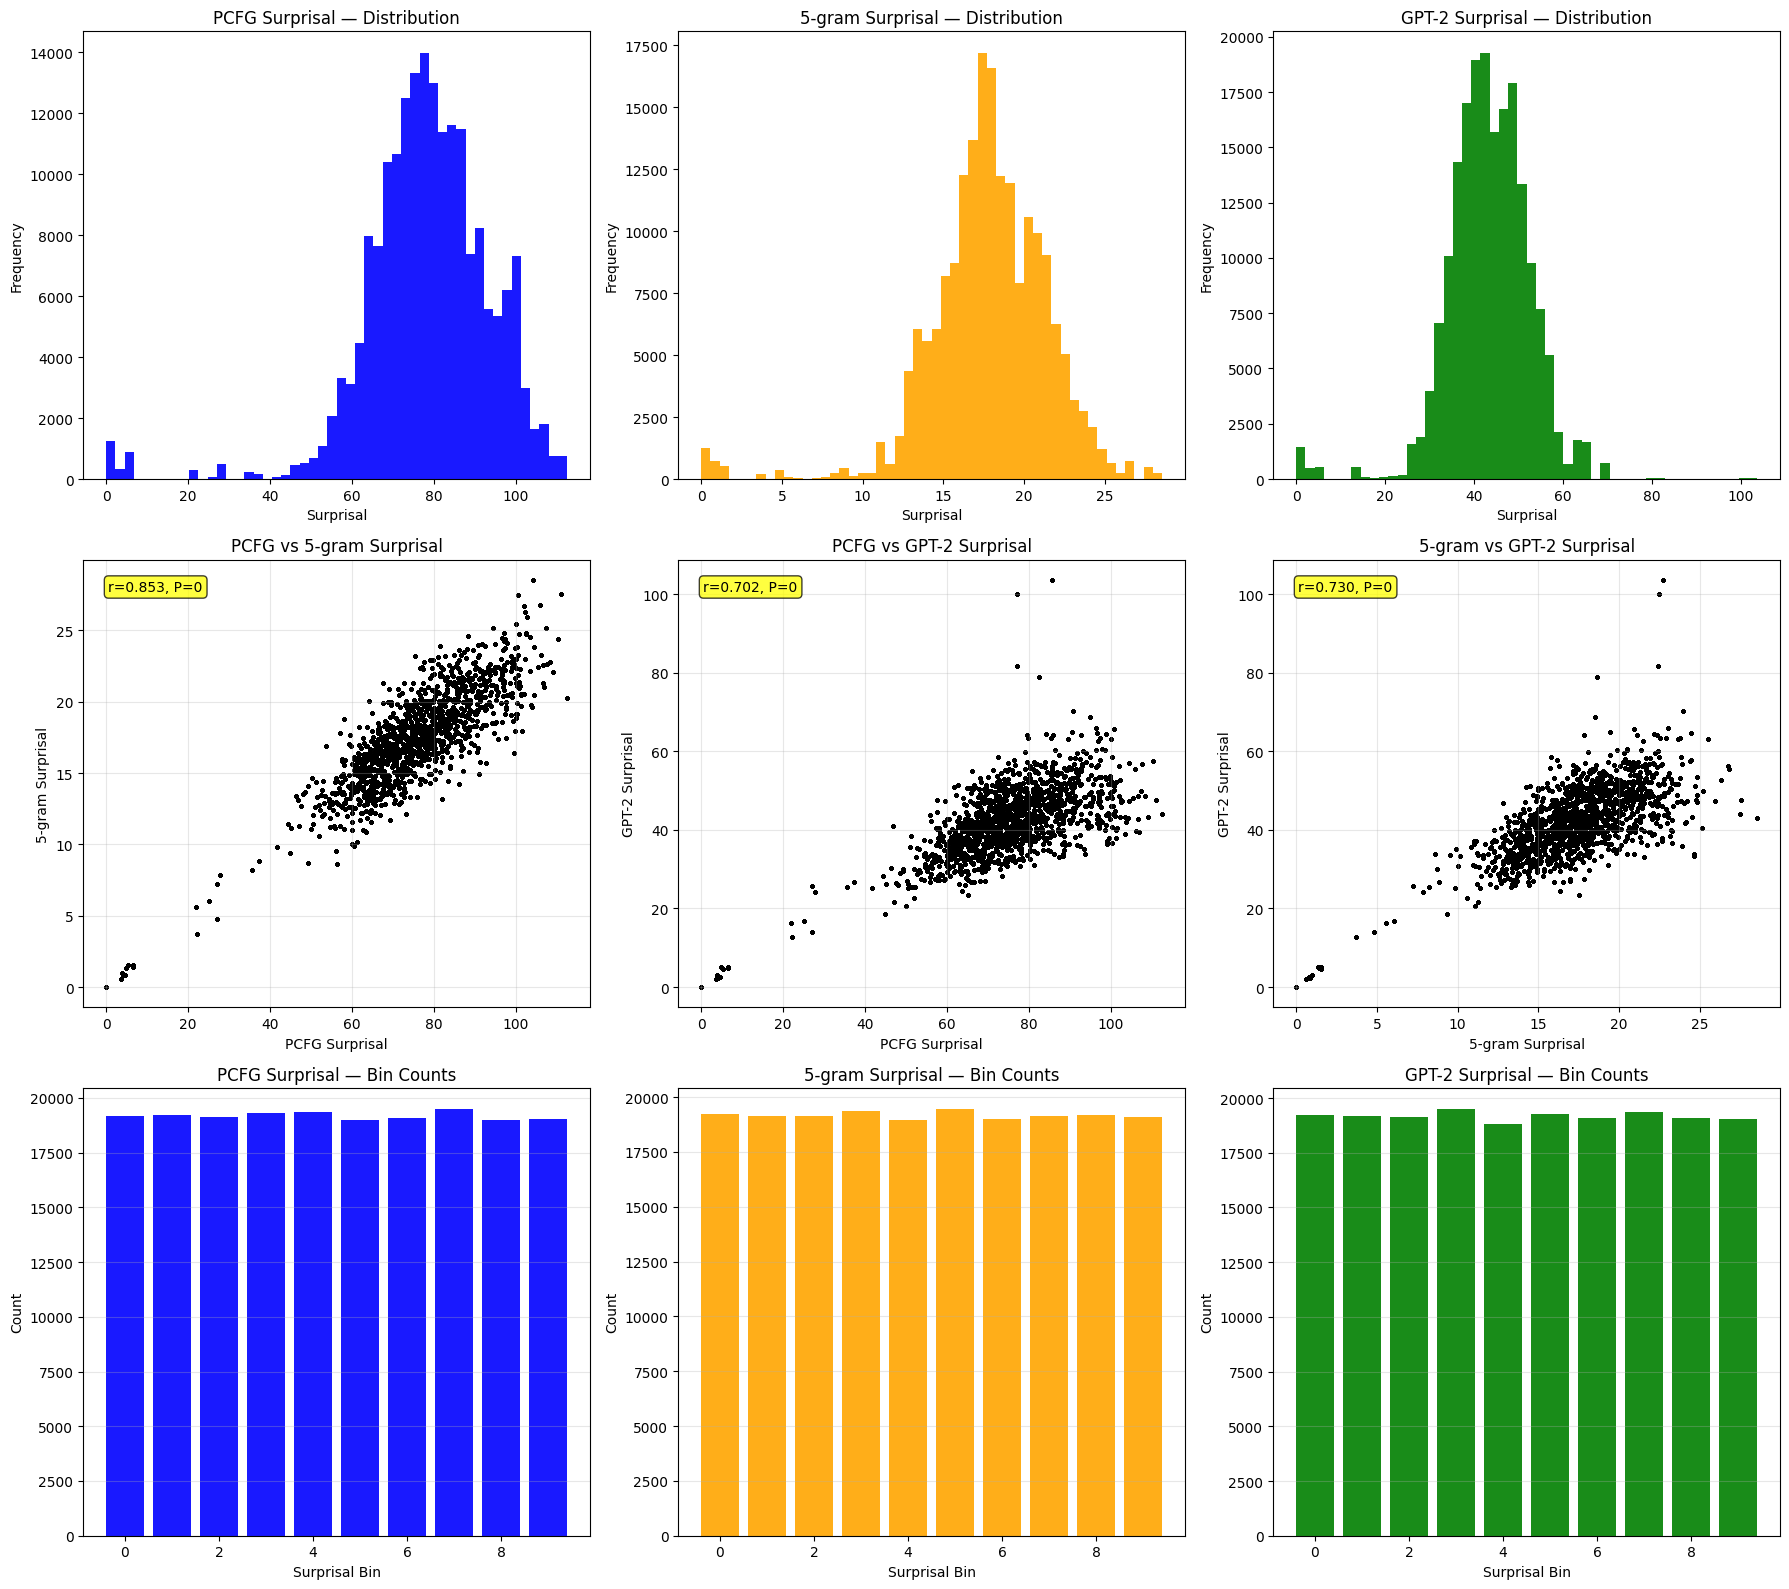


Summarizing BOLD across surprisal bins …

📊 Plotting per-fROI grids (network=1) …


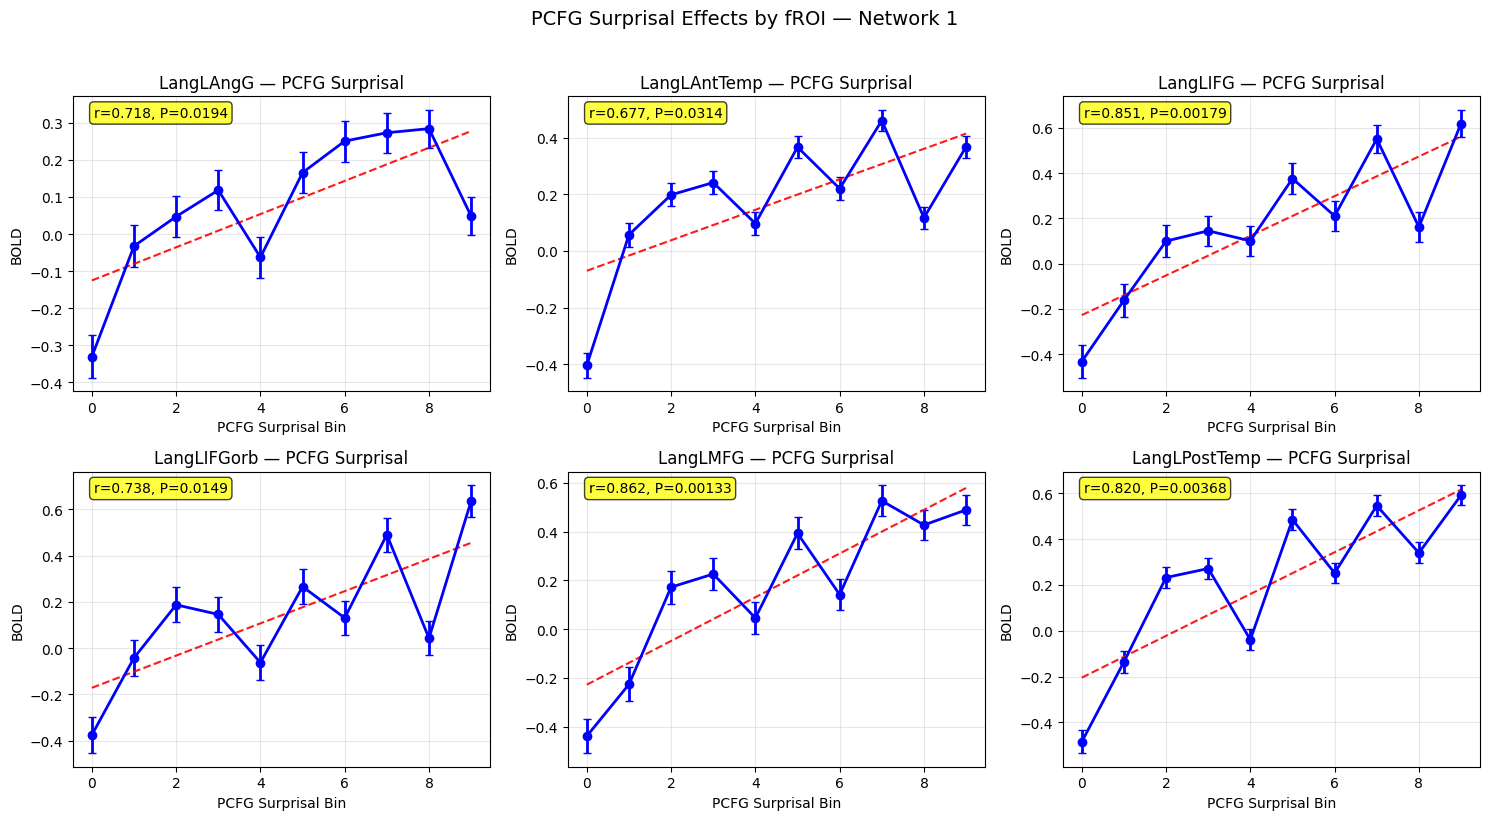

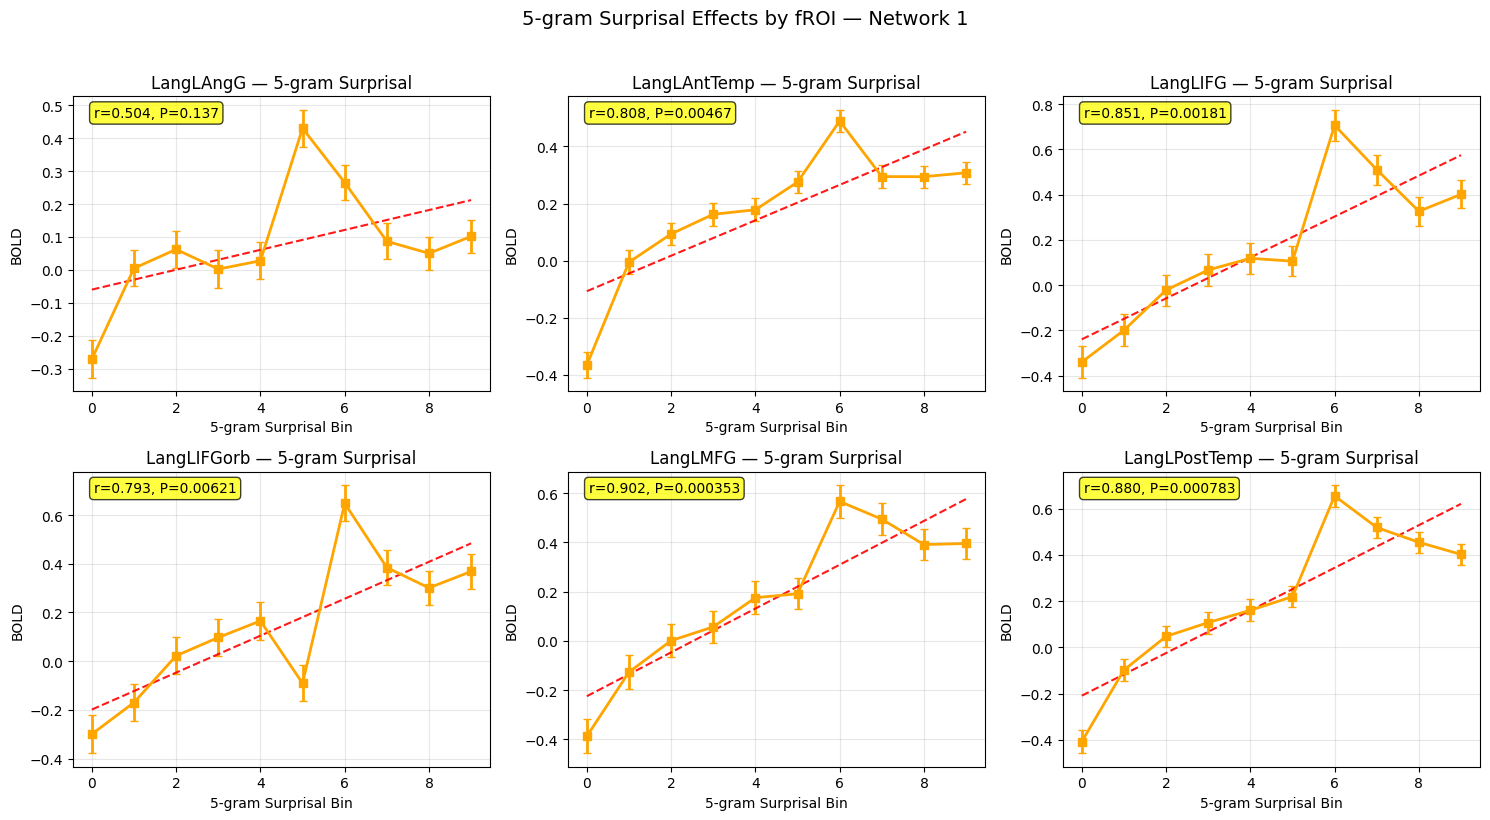

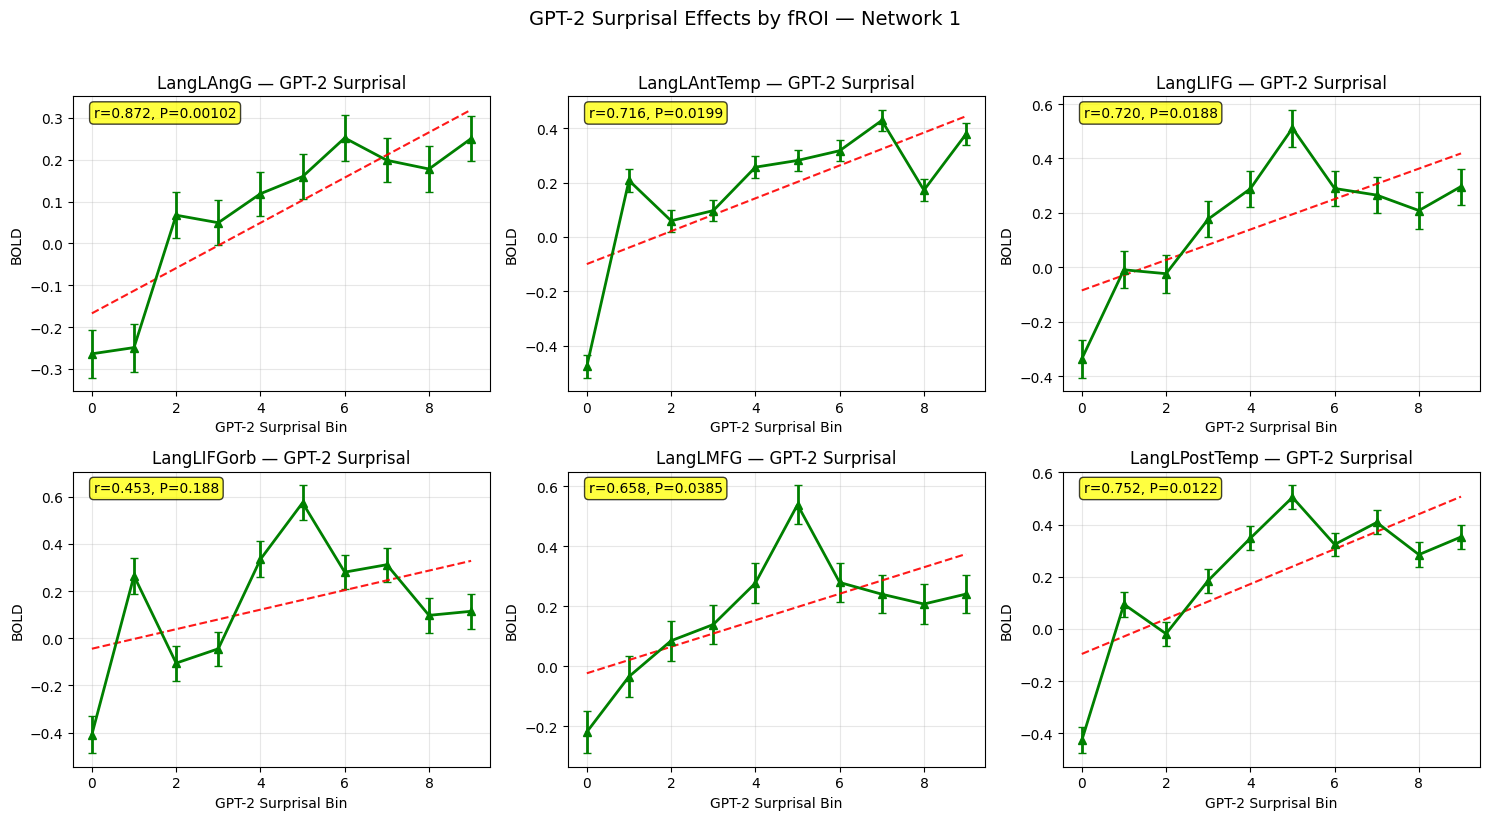


 Surprisal pipeline complete!


In [42]:
analyzed_df, outputs = run_full_surprisal_pipeline(merged, n_bins=10, per_network_max_frois=6)

In [47]:
def plot_all_frois_one_graph(merged_df, metric='pcfg', max_frois=None):
    """
    Single panel with ALL fROIs for one surprisal measure (PCFG / 5-gram / GPT-2).
    - No network filtering (assumes one network).
    - Reuses pipeline helpers & mappings; no seaborn.
    - Distinct color per fROI; clear x/y labels; legend outside.
    """
    # Reuse your helpers/mappings
    df = _rename_complexity_cols_to_surprisal(merged_df.copy())
    if metric not in REQ_SURP_COLS:
        raise ValueError(f"metric must be one of {list(REQ_SURP_COLS.keys())}")

    value_col, bin_col, _, _ = REQ_SURP_COLS[metric]
    _ensure_cols(df, ['BOLD', 'fROI', value_col])

    # If bins are missing, create them on the fly
    if bin_col not in df.columns:
        df, _ = create_surprisal_bins(df, value_col, n_bins=10)

    # Choose fROIs
    frois = df['fROI'].dropna().unique()
    if max_frois is not None:
        frois = frois[:max_frois]

    # Distinct colors for fROIs
    cmap = plt.cm.get_cmap('tab20', max(len(frois), 1))

    # Plot
    plt.figure(figsize=(12, 8))
    for i, froi in enumerate(frois):
        sub = df[df['fROI'] == froi]
        if sub.empty:
            continue
        grp = sub.groupby(bin_col)['BOLD'].agg(['mean', 'std', 'count'])
        if grp.empty:
            continue
        se = grp['std'] / np.sqrt(grp['count'])
        xs = grp.index.values.astype(float)
        ys = grp['mean'].values
        plt.errorbar(xs, ys, yerr=se.values,
                     marker='o', capsize=3, linewidth=2, markersize=6,
                     color=cmap(i), alpha=0.9, label=str(froi))

    # Labels & formatting
    metric_name = {'pcfg': 'PCFG', 'g5': '5-gram', 'gpt2': 'GPT-2'}[metric]
    plt.title(f'{metric_name} Surprisal — All fROIs in One Plot', fontsize=14)
    plt.xlabel(f'{metric_name} Surprisal Bin', fontsize=12)
    plt.ylabel('BOLD', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=9)
    plt.tight_layout()
    plt.subplots_adjust(right=0.78)
    plt.show()

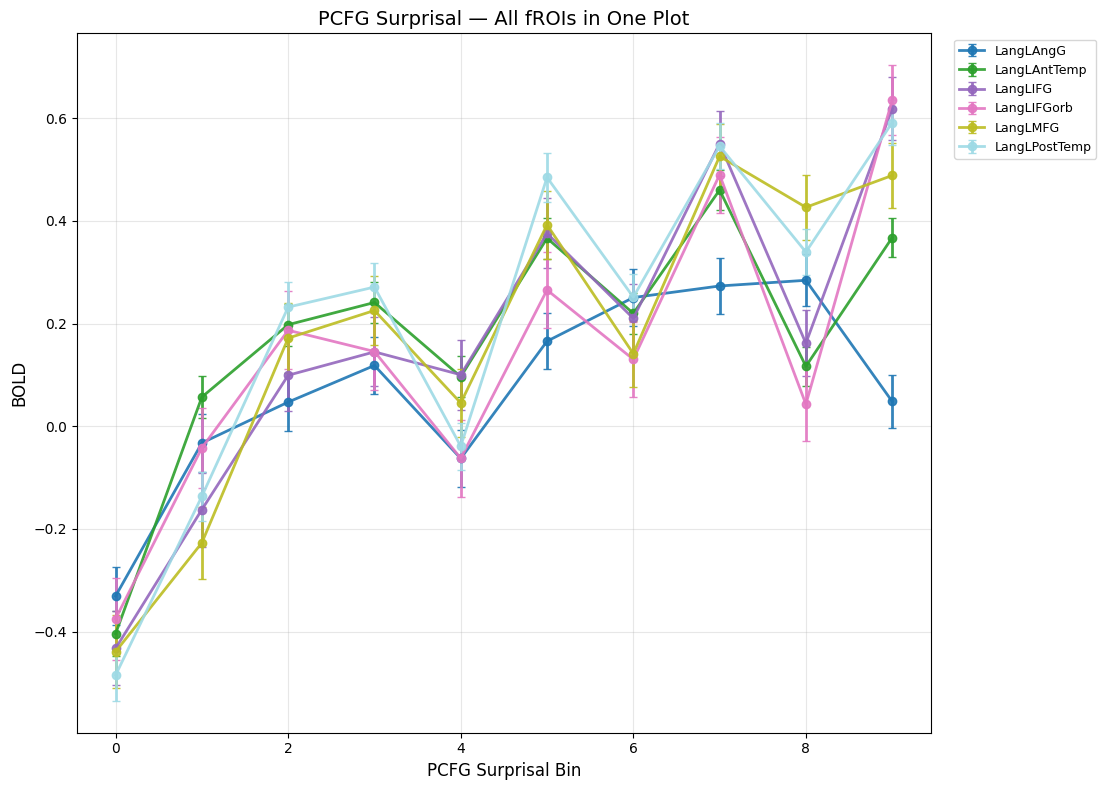

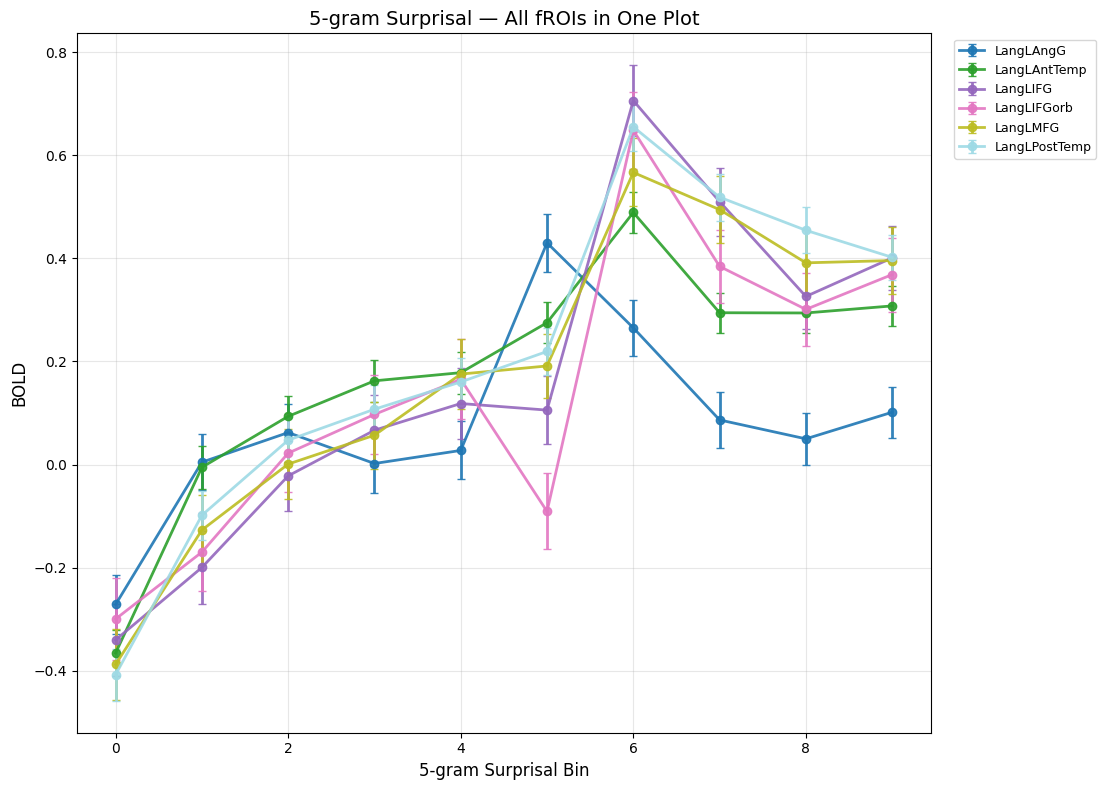

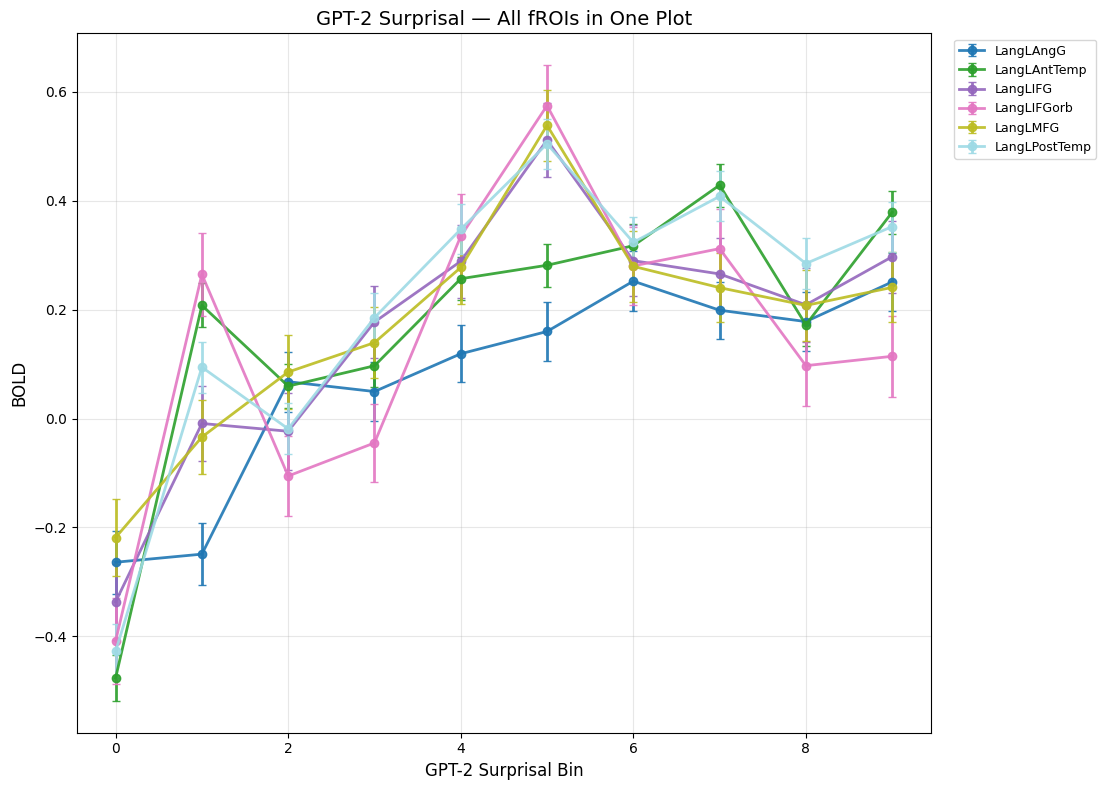

In [48]:
plot_all_frois_one_graph(analyzed_df, metric='pcfg', max_frois=12)
plot_all_frois_one_graph(analyzed_df, metric='g5', max_frois=12)
plot_all_frois_one_graph(analyzed_df, metric='gpt2', max_frois=12)